Files already downloaded and verified
Epoch [1/10], Loss: 0.0104
Epoch [2/10], Loss: 0.0100
Epoch [3/10], Loss: 0.0098
Epoch [4/10], Loss: 0.0097
Epoch [5/10], Loss: 0.0097
Epoch [6/10], Loss: 0.0096
Epoch [7/10], Loss: 0.0096
Epoch [8/10], Loss: 0.0096
Epoch [9/10], Loss: 0.0096
Epoch [10/10], Loss: 0.0096
Training Complete


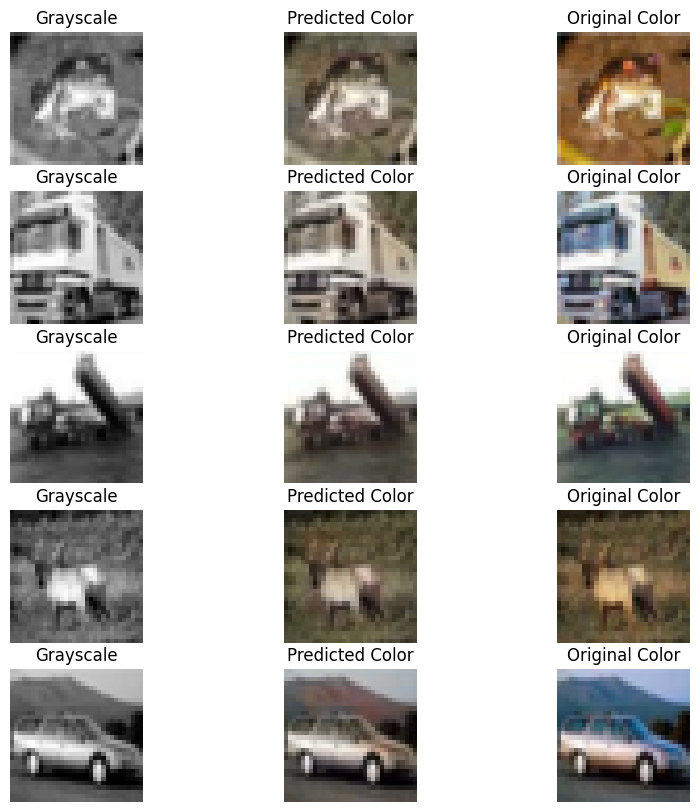

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image



class ColorizationDataset(Dataset):
    def __init__(self, root, transform=None):
        self.data = datasets.CIFAR10(root=root, train=True, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        
        # Apply transformations (if any) before color space conversion
        if self.transform:
            img = self.transform(img)
        
        # Convert the transformed image to a NumPy array for LAB conversion
        img_np = np.array(img.permute(1, 2, 0))  # Convert to HWC format for OpenCV
        
        # Convert to LAB color space
        img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        
        # Separate channels and normalize
        img_l = img_lab[:, :, 0] / 100.0  # Normalize L channel
        img_l = np.expand_dims(img_l, axis=0)  # Add channel dimension for grayscale input

        img_ab = img_lab[:, :, 1:3] / 128.0  # Normalize AB channels
        img_ab = np.transpose(img_ab, (2, 0, 1))  # Channels first for PyTorch compatibility

        # Convert L and AB channels to tensors
        img_l = torch.from_numpy(img_l).float()
        img_ab = torch.from_numpy(img_ab).float()

        return img_l, img_ab

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

train_dataset = ColorizationDataset(root='./data', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output color channels between -1 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ColorizationCNN()

# Step 4: Train the Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete")

# Step 5: Evaluation and Visualization
def visualize_colorization(model, dataset, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 3, figsize=(10, 10))
    
    for i in range(num_images):
        img_l, img_ab = dataset[i]
        img_l = img_l.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            pred_ab = model(img_l).squeeze(0).numpy()  # Remove batch dimension

        # Denormalize and reshape for visualization
        img_l_np = img_l.squeeze().numpy() * 100  # L channel in range 0-100
        pred_ab_np = pred_ab * 128  # AB channels in range -128 to 127

        # Combine L and AB channels and convert to RGB
        img_lab = np.zeros((32, 32, 3))
        img_lab[:, :, 0] = img_l_np
        img_lab[:, :, 1:] = pred_ab_np.transpose((1, 2, 0))
        img_rgb = cv2.cvtColor(img_lab.astype(np.float32), cv2.COLOR_LAB2RGB)
        img_rgb = np.clip(img_rgb, 0, 1)

        # Original grayscale and target color images
        orig_gray = img_l.squeeze().numpy()
        orig_color = np.zeros((32, 32, 3))
        orig_color[:, :, 0] = img_l_np
        orig_color[:, :, 1:] = img_ab.numpy().transpose((1, 2, 0)) * 128
        orig_color_rgb = cv2.cvtColor(orig_color.astype(np.float32), cv2.COLOR_LAB2RGB)
        orig_color_rgb = np.clip(orig_color_rgb, 0, 1)

        # Plot grayscale, predicted colorization, and original color
        axs[i, 0].imshow(orig_gray, cmap='gray')
        axs[i, 0].set_title("Grayscale")
        axs[i, 1].imshow(img_rgb)
        axs[i, 1].set_title("Predicted Color")
        axs[i, 2].imshow(orig_color_rgb)
        axs[i, 2].set_title("Original Color")
        
        for ax in axs[i]:
            ax.axis('off')

    plt.show()

# Visualize results
visualize_colorization(model, train_dataset)
